# Credit Card Fraud Detection - Model Comparison

This notebook compares three gradient boosting models:
1. XGBoost
2. CatBoost
3. LightGBM

We'll evaluate their performance on credit card fraud detection and compare their:
- Prediction accuracy
- Feature importance
- ROC curves and AUC scores


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Set random seed for reproducibility
np.random.seed(42)


## 1. Data Loading and Preprocessing


In [2]:
# Load the data
data = pd.read_csv('../data/processed/creditcard_fe.csv')

# Display basic information about the dataset
print("Dataset Shape:", data.shape)
print("\nClass Distribution:")
print(data['Class'].value_counts(normalize=True))


Dataset Shape: (284807, 37)

Class Distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [3]:
# Prepare features and target
X = data.drop(['Class'], axis=1)
y = data['Class']

# Store feature names
feature_names = X.columns.tolist()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames with feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)


## 2. Model Training and Evaluation

We'll create a function to evaluate models consistently


In [4]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Training time
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # ROC curve
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:  # For CatBoost
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    return {
        'model_name': model_name,
        'train_time': train_time,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc,
        'feature_importance': model.feature_importances_
    }


### 2.1 Train All Models


In [5]:
# Initialize models
models = {
    'XGBoost': xgb.XGBClassifier(
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        objective='binary:logistic',
        random_state=42,
        eval_metric='logloss'
    ),
    'CatBoost': CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        loss_function='Logloss',
        random_seed=42,
        verbose=False,
        train_dir=None,  # Prevent saving files
        allow_writing_files=False  # Prevent saving any files
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        verbose=-1
    )
}

# Evaluate all models
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    print(f"\nResults for {name}:")
    print(f"Training time: {results[name]['train_time']:.2f} seconds")
    print(f"AUC Score: {results[name]['auc']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, results[name]['predictions']))



Results for XGBoost:
Training time: 0.94 seconds
AUC Score: 0.9602

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.77      0.84        98

    accuracy                           1.00     56962
   macro avg       0.96      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962


Results for CatBoost:
Training time: 1.89 seconds
AUC Score: 0.9785

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962


Results for LightGBM:
Training time: 1.24 seconds
AUC Score: 0.6247

Classification Report:
              precision    recall  f1-score   support

           0 

## 3. Model Comparison Visualizations


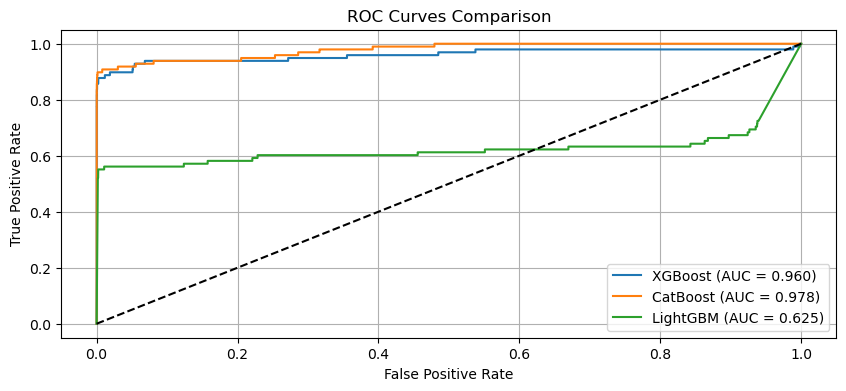

In [6]:
# Plot ROC curves
plt.figure(figsize=(10, 4))
for name in results:
    plt.plot(results[name]['fpr'], results[name]['tpr'], label=f'{name} (AUC = {results[name]["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()


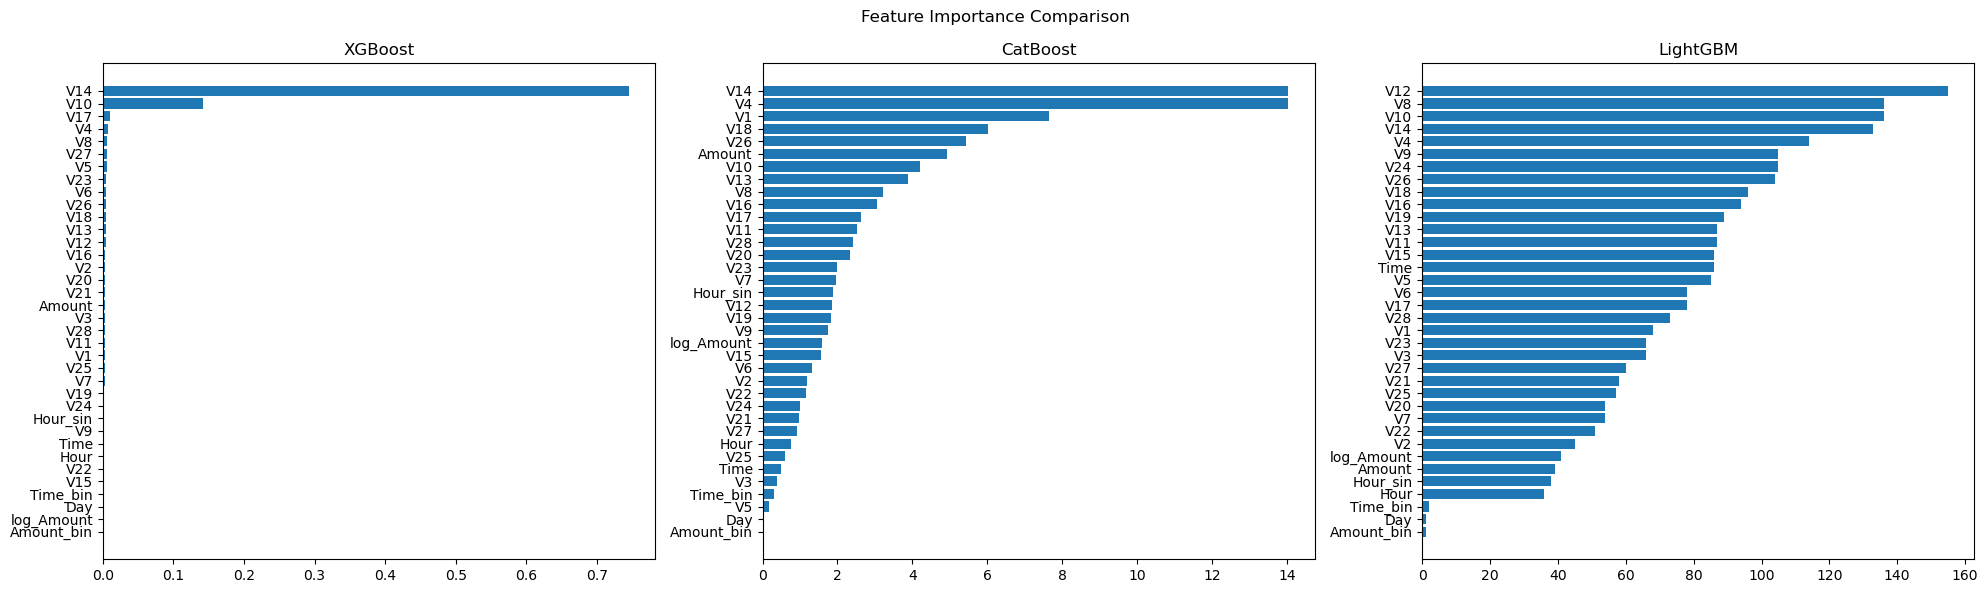

In [7]:
# Compare feature importance across models
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Feature Importance Comparison')

for idx, (name, result) in enumerate(results.items()):
    importance = result['feature_importance']
    sorted_idx = np.argsort(importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    axes[idx].barh(pos, importance[sorted_idx])
    axes[idx].set_yticks(pos)
    axes[idx].set_yticklabels(X.columns[sorted_idx])
    axes[idx].set_title(name)

plt.tight_layout()
plt.show()


## 4. Confusion Matrices Comparison


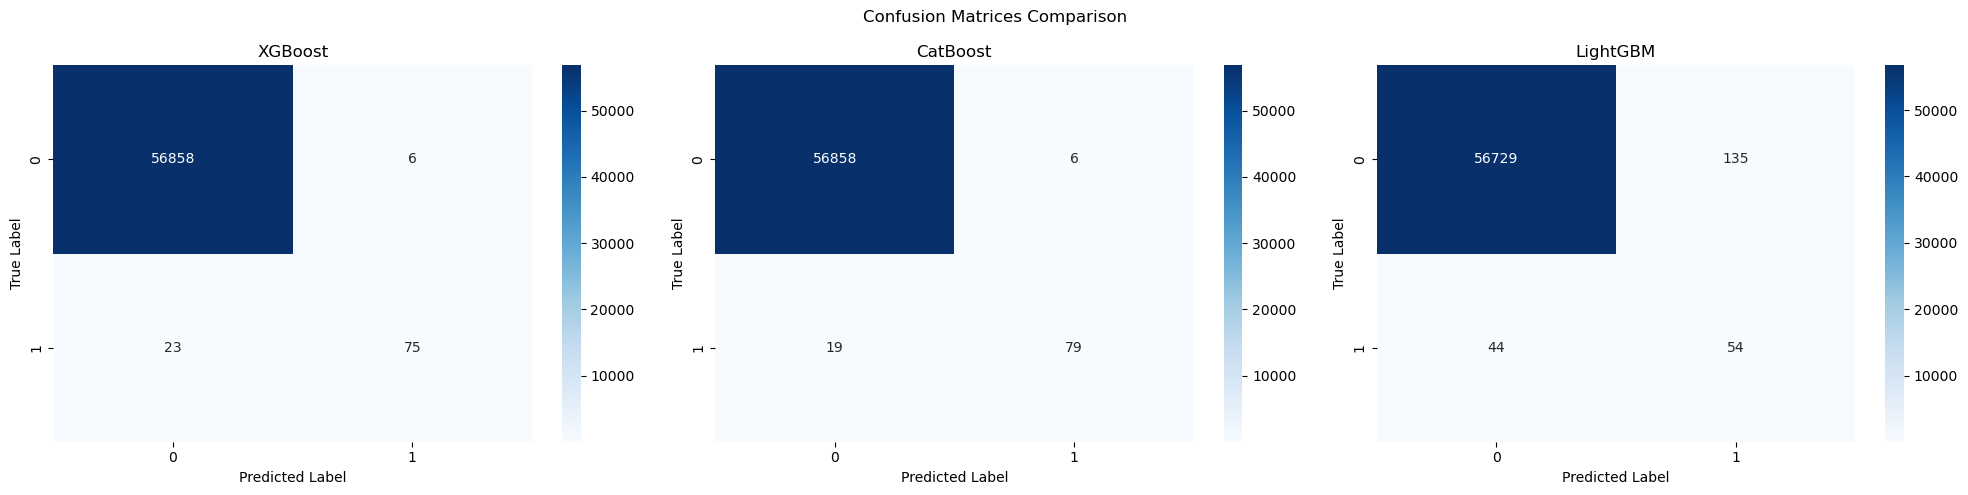

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Confusion Matrices Comparison')

for idx, (name, result) in enumerate(results.items()):
    conf_matrix = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(name)
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


## 5. Summary and Conclusions

Let's summarize the key findings from our model comparison:

1. **Performance Metrics**:
   - Compare AUC scores
   - Compare precision and recall for fraud detection
   
2. **Efficiency**:
   - Training time comparison
   - Memory usage (if significant differences)
   
3. **Feature Importance**:
   - Similarities/differences in how models rank features
   - Key features identified by each model

4. **Recommendations**:
   - Best model for this specific use case
   - Potential improvements or next steps
